# Reversible jump MCMC

This notebook implements the reversible jump MCMC example by Hastie and Green (2012, Statistica Neerlandica).

In [149]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting CUDA visible devices to [1]


In [150]:
from typing import NamedTuple
import jax
jax.config.update("jax_enable_x64", True) 
import jax.random as jrnd
import jax.numpy as jnp
from blackjax.base import SamplingAlgorithm
from blackjax.types import ArrayTree, PRNGKey
import distrax as dx

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import blackjax
from bamojax.base import Model
from bamojax.samplers import mcmc_sampler
from bamojax.inference import SMCInference

import matplotlib.pyplot as plt

Load English premiership data

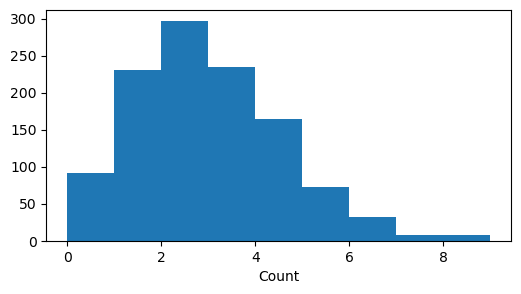

In [151]:
import pandas as pd

files = ['2005-06', '2006-07', '2007-08']
goals = []

for year in files:
    df = pd.read_csv(f'/scratch/big/home/maxhin/Documents/Code/Bayesian Model Comparison/data/English premiership/{year}.csv')  
    total_goals = df['FTHG'] + df['FTAG']
    total_goals_array = total_goals.to_numpy()
    goals.extend(total_goals_array)

Y = jnp.array(goals)
n = len(Y)
plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.hist(Y, bins=jnp.arange(0, 10, 1))
ax.set_xlabel('Goals')
ax.set_xlabel('Count');

Construct the two separate models:

In [152]:
def construct_poisson_model(observations) -> Model:
    model = Model('Poisson')
    rate_node = model.add_node('lam', distribution=dx.Gamma(concentration=25, rate=10))
    _ = model.add_node('Y', observations=observations, parents=dict(rate=rate_node), distribution=tfd.Poisson)
    return model

#
def construct_negative_binomial_model(observations) -> Model:
    # Note: Hastie & Green, Wikipedia, and TFD all have their own parametrizations of the negative binomial
    def negbin_link_fn(rate, dispersion):
        p = rate / (rate + 1 / dispersion)
        r = 1 / dispersion
        return dict(probs=p, total_count=r, require_integer_total_count=False)

    #

    model = Model('Negative binomial')
    rate_node = model.add_node('lam', distribution=dx.Gamma(concentration=25, rate=10)) 
    dispersion_node = model.add_node('kappa', distribution=dx.Gamma(concentration=1, rate=10))  
    _ = model.add_node('Y', observations=observations, parents=dict(rate=rate_node, dispersion=dispersion_node), distribution=tfd.NegativeBinomial, link_fn=negbin_link_fn)
    return model

#

poisson_model = construct_poisson_model(Y)
negbin_model = construct_negative_binomial_model(Y)

Run SMC inference for either model separately:

In [153]:
%%time
def model_probs(res):
    BF_poisson_negbin = jnp.exp(res[0]['lml'] - res[1]['lml'])
    pmp_poisson = BF_poisson_negbin / (1 + BF_poisson_negbin)
    pmp_negbin = 1 - pmp_poisson

    print(f'Posterior model probability Poisson model: {pmp_poisson:0.3f}')
    print(f'Posterior model probability Negative-Binomial model: {pmp_negbin:0.3f}')

#

models = [poisson_model, negbin_model]

for num_mutations in [100]:
    print(f'Number of MCMC steps: {num_mutations}')
    results = []

    for model in models:
        print(f'Inference for {model.name} model')
        mcmc_params = dict(sigma=0.1*jnp.eye(model.get_model_size()))
        rmh_kernel = mcmc_sampler(model, mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=mcmc_params)

        num_particles = 5_000
        num_chains = 1

        key = jrnd.PRNGKey(0)
        engine = SMCInference(model=model, num_chains=num_chains, mcmc_kernel=rmh_kernel, num_particles=num_particles, num_mutations=num_mutations)
        result = engine.run(key)
        results.append(result)
        print('\tLML: ', result['lml'])
    model_probs(results)


Number of MCMC steps: 100
Inference for Poisson model
	LML:  -2105.491195182895
Inference for Negative binomial model
	LML:  -2106.38876212516
Posterior model probability Poisson model: 0.710
Posterior model probability Negative-Binomial model: 0.290
CPU times: user 1min 29s, sys: 1.02 s, total: 1min 30s
Wall time: 1min 34s


An SMC-based marginal likelihood approach to getting the posterior model probabilities gives nearly identical results to Hastie & Green.

For comparison, here is the exact likelihood of the Gamma-Poisson model ($M_0$), which is strangely not that close...

In [154]:
import jax.numpy as jnp
from jax.scipy.special import gammaln

def gamma_poisson_log_marginal_likelihood(Y, alpha, beta):  
    log_prob = gammaln(alpha + Y) - gammaln(Y + 1) - gammaln(alpha) + alpha * jnp.log(beta / (beta + 1)) + Y * jnp.log(1 / (beta + 1))
    return jnp.sum(log_prob)

#
print(gamma_poisson_log_marginal_likelihood(Y, 25, 10)) 

alpha = 25.0
beta = 10.0

nb = tfd.NegativeBinomial(total_count=alpha, probs=1.0 / (beta + 1.0))
print(nb.log_prob(Y.astype(jnp.float32)).sum())

-2103.9705071352164
-2103.9712


Visualize posteriors; they are consistent with Hastie & Green.

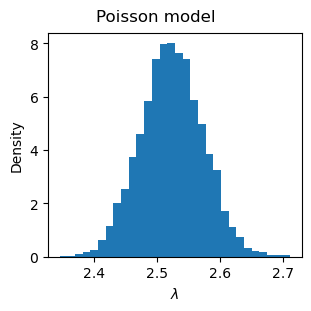

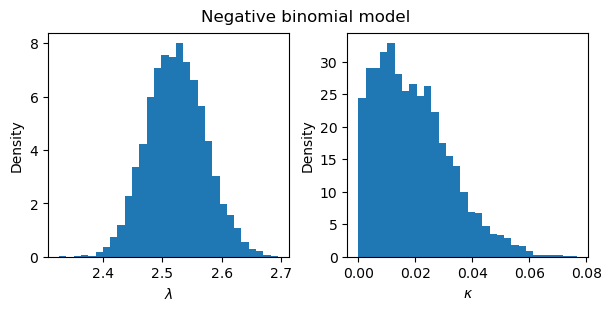

In [155]:
varnames_latex = {'kappa': r'$\kappa$', 'lam': r'$\lambda$'}

for res, model in zip(results, models):
    num_params = int(model.get_model_size())
    _, axes = plt.subplots(nrows=1, ncols=num_params, constrained_layout=True, figsize=(3*num_params, 3))
    if num_params == 1:
        axes = [axes]

    for i, varname in enumerate(model.get_latent_nodes()):
        axes[i].hist(res['final_state'].particles[varname].flatten(), bins=30, density=True)
        axes[i].set_xlabel(f'{varnames_latex[varname]}')
        axes[i].set_ylabel('Density')
    plt.suptitle(f'{model.name} model')

Other marginal likelihood estimators are reasonably consistent too. Note: IS depends heavily on importance density.

In [156]:
from bamojax.marginal_likelihoods import naive_monte_carlo, importance_sampling
from bamojax.inference import LaplaceInference

def lml2pmp(lml0, lml1):
    BF = jnp.exp(lml0 - lml1)
    pmp0 = BF / (1 + BF)
    pmp1 = 1 - pmp0
    return pmp0, pmp1

#

nmc_draws = 100_000
nmc_poisson = naive_monte_carlo(jrnd.PRNGKey(1), poisson_model, pb=False, num_prior_draws=nmc_draws)
nmc_negbin = naive_monte_carlo(jrnd.PRNGKey(1), negbin_model, pb=False, num_prior_draws=nmc_draws)

importance_distribution_poisson_model = {'lam': dx.Normal(loc=2.5, scale=0.3)}
importance_distribution_negbin_model = {'lam': dx.Normal(loc=2.5, scale=0.3), 'kappa': dx.Transformed(dx.Normal(loc=-1.0, scale=1.0), tfb.Exp())}

is_draws = 100_000
is_poisson = importance_sampling(jrnd.PRNGKey(2), poisson_model, g_IS=importance_distribution_poisson_model, num_samples=is_draws)
is_negbin = importance_sampling(jrnd.PRNGKey(2), negbin_model, g_IS=importance_distribution_negbin_model, num_samples=is_draws)

la_poisson = LaplaceInference(poisson_model, bounds=({'lam': (1e-6)}, {'lam': jnp.inf})).run(jrnd.PRNGKey(3))['lml']
la_negbin = LaplaceInference(negbin_model, bounds=({'lam': (1e-6), 'kappa': (1e-6)}, {'lam': jnp.inf, 'kappa': jnp.inf})).run(jrnd.PRNGKey(3))['lml']

names = ['Naive Monte Carlo', 'Importance Sampling', 'Laplace Approximation']

for name, lml_poisson, lml_negbin in zip(names, [nmc_poisson, is_poisson, la_poisson], [nmc_negbin, is_negbin, la_negbin]):
    pmp0, pmp1 = lml2pmp(lml_poisson, lml_negbin)
    print(f'Posterior model probability Poisson model ({name}): {pmp0:0.3f}')
    print(f'Posterior model probability Negative-Binomial model ({name}): {pmp1:0.3f}') 


Posterior model probability Poisson model (Naive Monte Carlo): 0.705
Posterior model probability Negative-Binomial model (Naive Monte Carlo): 0.295
Posterior model probability Poisson model (Importance Sampling): 0.752
Posterior model probability Negative-Binomial model (Importance Sampling): 0.248
Posterior model probability Poisson model (Laplace Approximation): 0.653
Posterior model probability Negative-Binomial model (Laplace Approximation): 0.347


Visualize Laplace approximation

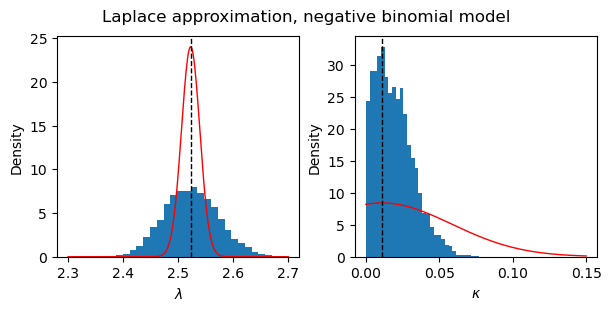

In [157]:
xranges = [jnp.linspace(2.3, 2.7, num=300), jnp.linspace(0, 0.15, num=200)]
_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6, 3))
varnames_latex = {'kappa': r'$\kappa$', 'lam': r'$\lambda$'}

for i, (xrange, varname) in enumerate(zip(xranges, negbin_model.get_latent_nodes())):
    axes[i].hist(res['final_state'].particles[varname].flatten(), bins=30, density=True)
    loc = negbin_laplace['mode'][varname]
    scale = negbin_laplace['covariance'][i, i] ** 0.5

    axes[i].plot(xrange, dx.Normal(loc=loc, scale=scale).prob(xrange), color='r', lw=1)
    axes[i].axvline(x=loc, ls='--', color='k', lw=1)
    axes[i].set_xlabel(varnames_latex[varname])
    axes[i].set_ylabel('Density')
plt.suptitle(f'Laplace approximation, {negbin_model.name.lower()} model');

Now let's use a MetaModel and reversible-jump MCMC as provided by bamojax:

Time taken for MCMC inference: 25.11 seconds
Probability of Poisson model: 0.7044444444444444
Probability of negative binomial model: 0.29555555555555557
Acceptance rate of within-model moves: 0.3683977
Acceptance rate of between-model moves: 0.58759075
Time taken for SMC inference: 29.96 seconds
Probability of Poisson model: 0.7092799999999999
Probability of negative binomial model: 0.29072000000000003


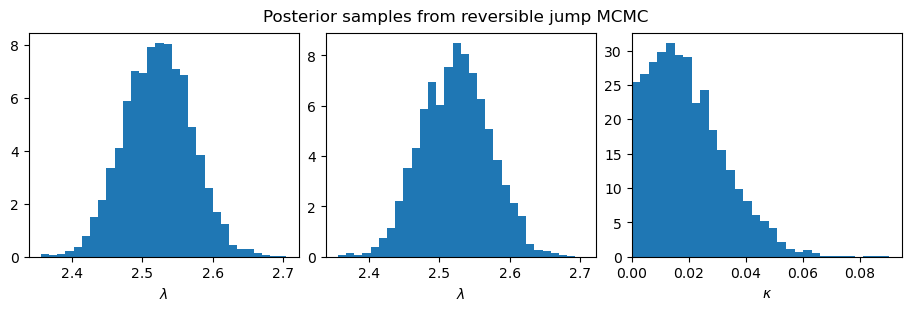

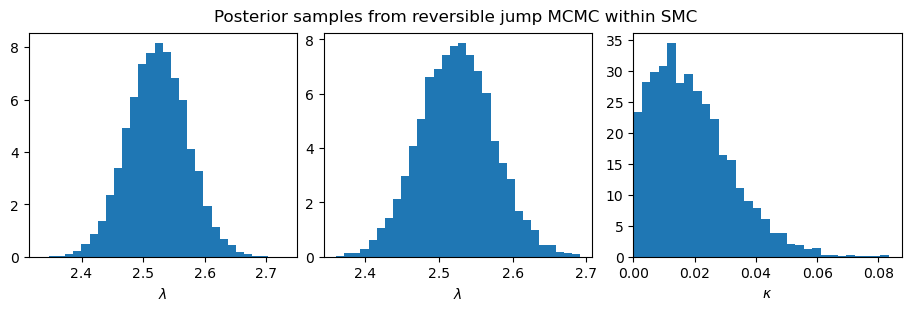

In [158]:
from bamojax.inference import MCMCInference, SMCInference
from bamojax.samplers import reversible_jump_mcmc
from bamojax.base import MetaModel
import time

def plot_posterior(samples):
    poisson_model_params = jax.tree_util.tree_map(lambda x: {'lam': x[samples['model_index']==0]}, samples['lam'])
    negbin_model_params = jax.tree_util.tree_map(lambda x, y: {'lam': x[samples['model_index']==1], 'kappa': y[samples['model_index']==1]}, samples['lam'], samples['kappa'])

    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(9, 3))
    axes[0].hist(poisson_model_params['lam'], bins=30, density=True)
    axes[1].hist(negbin_model_params['lam'], bins=30, density=True)
    axes[2].hist(negbin_model_params['kappa'], bins=30, density=True)

    for ax in [axes[0], axes[1]]:
        ax.set_xlabel(r'$\lambda$')
    axes[-1].set_xlabel(r'$\kappa$')
    axes[-1].set_xlim(left=0)

    return fig, axes

#

model_list = [poisson_model, negbin_model]
metamodel = MetaModel(model_list)
within_model_kernels = [dict(mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=dict(sigma=0.1*jnp.eye(model.get_model_size()))) for model in model_list]

# proposal parameters
sigma_aux = 1.5
auxiliary_proposal_dist = dx.Normal(loc=0.0, scale=sigma_aux)
mu_aux = 0.015

# reversible jump auxiliary variable projection functions
# auxiliary variables are named f'u_{i}', with i = 0, ..., num_auxiliary - 1.

def project_up(u_0):
    return mu_aux * jnp.exp(u_0)

#
def project_down(position):
    kappa = position['kappa']
    return jnp.log(kappa / mu_aux)  

#
def jump_fn_up(position, u_0):
    return dict(lam=position['lam'], kappa=project_up(u_0), u_0=u_0)

#
def jump_fn_down(position):
    return dict(lam=position['lam'], kappa=position['kappa'], u_0=project_down(position))

#
def jacobian_det_up(u_0):
    return jnp.abs(project_up(u_0))  

#
def jacobian_det_down(kappa):
    return 1. / kappa

#

jump_functions = [jump_fn_up, jump_fn_down]
jacobians = [jacobian_det_up, jacobian_det_down]
projections = [project_up, project_down]

# Compare MCMC and SMC inference
do_mcmc = True
do_smc = True
if do_mcmc:
    rjmcmc_kernel = reversible_jump_mcmc(models=metamodel.model_list, 
                                         auxiliary_proposal_dist=auxiliary_proposal_dist,
                                         jump_functions=jump_functions,
                                         jacobians=jacobians,
                                         projections=projections,
                                         within_model_kernels=within_model_kernels) 

    num_burn = 5_000
    num_samples = 50_000
    engine = MCMCInference(model=metamodel,
                           mcmc_kernel=rjmcmc_kernel,
                           num_chains=1,
                           num_samples=num_samples,
                           num_burn=num_burn,
                           return_diagnostics=True)

    tic = time.time()
    results = engine.run(jrnd.PRNGKey(0))
    toc = time.time()
    print(f'Time taken for MCMC inference: {toc - tic:.2f} seconds')
    states = results['states']
    info = results['info']
    states = jax.tree_util.tree_map(lambda x: x[num_burn:], states)
    info = jax.tree_util.tree_map(lambda x: x[num_burn:], info)

    pmp1 = jnp.mean(states['model_index'])
    pmp0 = 1 - pmp1

    print('Probability of Poisson model:', pmp0)
    print('Probability of negative binomial model:', pmp1)
    print('Acceptance rate of within-model moves:', jnp.mean(info['is_accepted'][jnp.where(info['within_model_move'])[0]]))
    print('Acceptance rate of between-model moves:', jnp.mean(info['is_accepted'][jnp.where(1 - info['within_model_move'])[0]]))

    fig, axes = plot_posterior(states)
    fig.suptitle('Posterior samples from reversible jump MCMC')


if do_smc:
    rjmcmc_kernel = reversible_jump_mcmc(models=metamodel.model_list, 
                                         auxiliary_proposal_dist=auxiliary_proposal_dist,
                                         jump_functions=jump_functions,
                                         jacobians=jacobians,
                                         projections=projections,
                                         within_model_kernels=within_model_kernels) 

    engine = SMCInference(model=metamodel,
                          mcmc_kernel=rjmcmc_kernel,
                          num_chains=1,
                          num_particles=25_000,
                          num_mutations=2,
                          return_diagnostics=False)

    tic = time.time()
    results_smc = engine.run(jrnd.PRNGKey(0))
    toc = time.time()
    print(f'Time taken for SMC inference: {toc - tic:.2f} seconds')

    particles = results_smc['final_state'].particles

    pmp1 = jnp.mean(particles['model_index'])
    pmp0 = 1 - pmp1 

    print('Probability of Poisson model:', pmp0)
    print('Probability of negative binomial model:', pmp1)

    fig, axes = plot_posterior(particles)
    fig.suptitle('Posterior samples from reversible jump MCMC within SMC')